<a href="https://colab.research.google.com/github/jmhuer/shift_invariant_dictionary_learning/blob/main/chordanalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pretty_midi
!git clone https://github.com/jmhuer/ModularSparseAutoencoder
!git clone https://github.com/music-x-lab/POP909-Dataset
!git clone https://github.com/jmhuer/HT
!git clone https://github.com/Tsung-Ping/functional-harmony
# %cd /content/POP909-Dataset/data_process
!pip install libfmp

fatal: destination path 'ModularSparseAutoencoder' already exists and is not an empty directory.
fatal: destination path 'POP909-Dataset' already exists and is not an empty directory.
fatal: destination path 'HT' already exists and is not an empty directory.
fatal: destination path 'functional-harmony' already exists and is not an empty directory.


In [1]:
#@title Pytorch for DL

import torch.nn.functional as F
import torch.optim as optim
from torch import nn
import torch
from torch.nn.utils import weight_norm
import numpy as np
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Using device: ", device)


def get_model_parameters(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

Using device:  cuda


# This preprocesses data and creates pickle


In [2]:

# !pip install tensorflow-gpu==1.15
from HT.chord_symbol_recognition import train_HT
from collections import Counter, namedtuple


# Chord symbol recognition
# train_BTC() # Bi-directional Transformer for Chord Recognition
# train_CRNN() # Convolutional Recurrent Neural Network
root_dict = {'C': 0, 'C+': 1, 'D': 2, 'D+': 3, 'E': 4, 'F': 5, 'F+': 6, 'G': 7, 'G+': 8, 'A': 9, 'A+': 10, 'B': 11, 'pad': 12}
tquality_dict = {'M': 0, 'm': 1, 'O': 2, 'pad': 3}  # 'O' stands for 'others'
n_chord_classes = 24 + 1  # 24 major-minor modes plus 1 others


# Hyperparameters
hyperparameters = namedtuple('hyperparameters',
                              ['dataset',
                              'test_set_id',
                              'graph_location',
                              'n_root_classes',
                              'n_tquality_classes',
                              'n_chord_classes',
                              'n_steps',
                              'input_embed_size',
                              'n_layers',
                              'n_heads',
                              'train_sequence_with_overlap',
                              'initial_learning_rate',
                              'drop',
                              'n_batches',
                              'n_training_steps',
                              'n_in_succession',
                              'annealing_rate'])

hp = hyperparameters(dataset='/content/', # {'BPS_FH', 'Preludes'}
                      test_set_id=1, # {1, 2, 3, 4}
                      graph_location='model',
                      n_root_classes=len(root_dict.keys()),
                      n_tquality_classes=len(tquality_dict.keys()),
                      n_chord_classes=n_chord_classes,
                      n_steps=128,
                      input_embed_size=128,
                      n_layers=2,
                      n_heads=4,
                      train_sequence_with_overlap=True,
                      initial_learning_rate=1e-4,
                      drop=0.1,
                      n_batches=40,
                      n_training_steps=100000,
                      n_in_succession=10,
                      annealing_rate=1.1)

Instructions for updating:
non-resource variables are not supported in the long term


In [5]:
from HT.BPS_FH_preprocessing import main

main()

Message: load note data ...
lowest pitch = 24 highest pitch =  101
Message: load chord labels...
Message: get framewise labels ...
max_length = 8482
min_length = 872
keys in corpus['op'] = dict_keys(['pianoroll', 'chromagram', 'start_time', 'label'])
label fields =  [('op', '<U10'), ('onset', '<f8'), ('key', '<U10'), ('degree1', '<U10'), ('degree2', '<U10'), ('quality', '<U10'), ('inversion', '<i8'), ('rchord', '<U10'), ('root', '<U10'), ('tquality', '<U10'), ('chord_change', '<i8')]
Running Message: augment data...
keys in corpus_aug['shift_id']['op'] = dict_keys(['pianoroll', 'tonal_centroid', 'start_time', 'label'])
Running Message: reshape data...
keys in corpus_aug_reshape['shift_id']['op'] = dict_keys(['pianoroll', 'tonal_centroid', 'start_time', 'label', 'len'])
sequence_len_non_overlaped = [17, 22, 23, 24, 30, 34, 36, 40, 44, 48, 52, 53, 66, 72, 80, 84, 86, 88, 100, 102, 104, 116, 118, 120, 128]
sequence_len_overlaped = [17, 22, 23, 24, 30, 34, 36, 40, 44, 48, 52, 53, 66, 72, 8

# Make pytorch dataloader

In [3]:
# !pip install tensorflow-gpu==1.15
from HT.chord_symbol_recognition import train_HT
from collections import Counter, namedtuple
from HT.BPS_FH_preprocessing import main
from HT.chord_symbol_recognition import load_data_symbol
#

import pickle
import os
import sys
# import utils
import pretty_midi 
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch


class BPS(Dataset):
    def __init__(self, data):
        "todo: transpose"
        self.all_data = []
        temp = []
        self.label = []
        temp2 = []
        self.chord_change = []
        temp3 = []      
        i = 0 
        for pi,chord, cc in zip(data["pianoroll"],data["tchord"],data['label']['chord_change']):
            temp.append(torch.tensor(pi).double())
            temp2.append(torch.tensor(chord).double())
            temp3.append(torch.tensor(cc).double())
            i+=1
            if i > 30000: break
        self.all_data = torch.cat(temp)
        self.label = torch.cat(temp2)
        self.chord_change = torch.cat(temp3)
        print("data" , self.all_data.shape)
        print("label" , self.label.shape)
        ##time.sleep(120)
        self.transform = self.make_transform()
    def __len__(self):
        return len(self.all_data)
    def __getitem__(self, idx):
        piano_roll_slice = self.all_data[idx,:]
        label_slice = self.label[idx]
        chord_change_slice = self.chord_change[idx]
        tranformed_piano_roll_slice = self.transform["norm"](piano_roll_slice[None][None])[0,0,:]
        #print(tranformed_piano_roll_slice.shape)
        #print("label_slice", label_slice)
        return tranformed_piano_roll_slice, label_slice, chord_change_slice
    def make_transform(self):
        mean = self.all_data.mean()
        std = self.all_data.std() * 2
        # print("mean ", mean.shape)
        # print("std ", std.shape)
        tensor_transform = {
          'norm':
              transforms.Compose([
                  transforms.Normalize([mean], [std])  # Imagenet standards
              ]),
          "inverse_norm":
                transforms.Normalize(
                  mean= [-m/s for m, s in zip([mean], [std])],
                  std= [1/s for s in [std]]
                )
            }
        return tensor_transform


def load_data(train_data, test_data,  num_workers=0, batch_size=16, random_seed = 40):
    '''
    this data loading proccedure assumes dataset/train/ dataset/val/ folders
    also assumes transform dictionary with train and val
    '''
    dataset_train = BPS(train_data) 
    dataset_val = BPS(test_data) 

    print("Size of train dataset: ",len(dataset_train))
    print("Size of val dataset: ",len(dataset_val))

    dataloaders = {
        'train': DataLoader(dataset_train, batch_size=batch_size, shuffle=False, drop_last=True),
        'val': DataLoader(dataset_val, batch_size=batch_size, shuffle=False, drop_last=True)
    }
    return dataloaders



##only tensor transforms



train_data, test_data = load_data_symbol(dir=hp.dataset + 'BPS_FH_preprocessed_data_MIREX_Mm.pickle', test_set_id=hp.test_set_id, sequence_with_overlap=hp.train_sequence_with_overlap)
print("load_data_symbol train_data size: {}".format(train_data["tchord"].shape))



dataset = load_data(train_data, test_data, batch_size=16)



Load chord symbol data...
test_set_id = 1
keys in corpus_aug_reshape['shift_id']['op'] = dict_keys(['pianoroll', 'tonal_centroid', 'start_time', 'label', 'len'])
shift_list = ['shift_-1', 'shift_-2', 'shift_-3', 'shift_0', 'shift_1', 'shift_2', 'shift_3', 'shift_4', 'shift_5', 'shift_6']
train_op_list = ['2', '3', '4', '6', '7', '8', '10', '11', '12', '14', '15', '16', '18', '19', '20', '22', '23', '24', '26', '27', '28', '30', '31', '32']
test_op_list = ['1', '5', '9', '13', '17', '21', '25', '29']
train_data:  [('pianoroll', (54320, 128, 88)), ('tonal_centroid', (54320, 128, 6)), ('len', (54320,)), ('label', (54320, 128)), ('root', (54320, 128)), ('tquality', (54320, 128)), ('tchord', (54320, 128))]
test_data:  [('pianoroll', (294, 128, 88)), ('tonal_centroid', (294, 128, 6)), ('len', (294,)), ('label', (294, 128)), ('root', (294, 128)), ('tquality', (294, 128)), ('tchord', (294, 128))]
label fields: [('op', '<U10'), ('onset', '<f8'), ('key', '<U10'), ('degree1', '<U10'), ('degree2',

#play example from BPS dataset

In [4]:


def piano_roll_to_pretty_midi(piano_roll, fs=8, program=0):
    '''Convert a Piano Roll array into a PrettyMidi object
     with a single instrument.
    Parameters
    ----------
    piano_roll : np.ndarray, shape=(128,frames), dtype=int
        Piano roll of one instrument
    fs : int
        Sampling frequency of the columns, i.e. each column is spaced apart
        by ``1./fs`` seconds.
    program : int
        The program number of the instrument.
    Returns
    -------
    midi_object : pretty_midi.PrettyMIDI
        A pretty_midi.PrettyMIDI class instance describing
        the piano roll.
    '''
    notes, frames = piano_roll.shape
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=program)

    # pad 1 column of zeros so we can acknowledge inital and ending events
    piano_roll = np.pad(piano_roll, [(0, 0), (1, 1)], 'constant')

    # use changes in velocities to find note on / note off events
    velocity_changes = np.nonzero(np.diff(piano_roll).T)

    # keep track on velocities and note on times
    prev_velocities = np.zeros(notes, dtype=int)
    note_on_time = np.zeros(notes)

    for time, note in zip(*velocity_changes):
        # use time + 1 because of padding above
        velocity = piano_roll[note, time + 1]
        time = time / fs
        if velocity > 0:
            if prev_velocities[note] == 0:
                note_on_time[note] = time
                prev_velocities[note] = velocity
        else:
            pm_note = pretty_midi.Note(
                velocity=prev_velocities[note],
                pitch=note,
                start=note_on_time[note],
                end=time)
            instrument.notes.append(pm_note)
            prev_velocities[note] = 0
    pm.instruments.append(instrument)
    return pm




In [5]:
import IPython.display
index = 45 ## 44 66 & 0 & 1 500 omg 1021

#lets play a batch 
tr = dataset["val"].dataset.transform["inverse_norm"]
listen = []
for i,ba in enumerate(dataset["val"]): 
    ##print(ba[0].shape)
    if i < index: 
        continue
    listen.append(tr(ba[0][:,None,None,:]))
    if len(listen)==10: 
        piano_roll = torch.cat(listen)[:,0,0,:].T
        break

def pad88to128(piano_roll):
    arr = np.zeros((128,int(piano_roll.shape[1])))
    pad = (128 - 88)//2
    arr[pad:(128-pad),0:arr.shape[1]] = piano_roll
    return arr

arr = pad88to128(piano_roll)
pm = piano_roll_to_pretty_midi(arr)
IPython.display.Audio(pm.synthesize(fs=16000), rate=16000)


In [6]:
import argparse
import datetime
import json
import os

import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim




def get_args():
    parser = argparse.ArgumentParser()

    # Architecture Flags
    parser.add_argument('--intermediate_dim', type=int, default=48)
    parser.add_argument('--stripe_dim', type=int, default=24)
    parser.add_argument('--num_stripes', type=int, default=15)
    parser.add_argument('--num_active_neurons', type=int, default=24)
    parser.add_argument('--num_active_stripes', type=int, default=3)
    parser.add_argument('--layer_sparsity_mode', type=str, default='lifetime')  # Set to none, ordinary, boosted, or lifetime.
    parser.add_argument('--stripe_sparsity_mode', type=str, default='routing')  # Set to none, ordinary, or routing.
    parser.add_argument('--distort_prob', type=float, default=.01)  # Probability of stripe sparsity mask bits randomly flipping.
    parser.add_argument('--distort_prob_decay', type=float, default=.025)  # Lowers distort_prob by this amount every epoch.

    # Boosting Flags - Only necessary when layer_sparsity_mode is set to boosted.
    parser.add_argument('--alpha', type=float, default=.8)
    parser.add_argument('--beta', type=float, default=1.2)


    # Routing Flags - Only necessary when stripe_sparsity_mode is set to routing.
    parser.add_argument('--routing_l1_regularization', type=float, default=0.1)
    parser.add_argument('--log_average_routing_scores', type=bool, default=True)

    # Lifetime Stripe Flag - Only necessary when stripe_sparsity_mode is set to lifetime.
    # Within a stripe, this specifies the proportion of samples that may activate the stripe.
    parser.add_argument('--active_stripes_per_batch', type=float, default=4)

    # Training Flags
    parser.add_argument('--lr', type=float, default=.0001)
    parser.add_argument('--momentum', type=float, default=.1)
    parser.add_argument('--num_epochs', type=int, default=1)
    parser.add_argument('--batch_size', type=int, default=8)
    parser.add_argument('--data_path', type=str, default='data.csv')
    parser.add_argument('--log_path', type=str, default='logs')
    parser.add_argument('--log_class_specific_losses', type=bool, default=False)
    parser.add_argument('--log_average_activations', type=bool, default=True)
    parser.add_argument('--use_cuda_if_available', type=bool, default=True)

    args, unknown = parser.parse_known_args()
    return vars(args)
args = get_args()
print(args["intermediate_dim"])

48


In [7]:
from ModularSparseAutoencoder.model import Net
from ModularSparseAutoencoder.train import train


num_stripes = args['num_stripes']
num_epochs = args['num_epochs']
batch_size = args['batch_size']

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

net = Net(args['intermediate_dim'],
          args['stripe_dim'],
          args['num_stripes'],
          args['num_active_neurons'],
          args['num_active_stripes'],
          args['layer_sparsity_mode'],
          args['stripe_sparsity_mode'],
          args['distort_prob'],
          args['alpha'],
          args['beta'],
          args['active_stripes_per_batch'],
          device).double().to(device)

# net.load_state_dict(torch.load("/content/net.pth"))

criterion = nn.MSELoss().to(device)
# optimizer = optim.SGD(net.parameters(),
#                       lr=args['lr'],
#                       momentum=args['momentum'])
optimizer = optim.Adam(net.parameters(), lr=args['lr'],  
                       betas=(0.8, 0.999), eps=1e-08, weight_decay=0, amsgrad=True) ##this has weight decay just like you implemented

timestamp = str(datetime.datetime.now()).replace(' ', '_')
root_path = os.path.join(args['log_path'],
                          args['layer_sparsity_mode'],
                          args['stripe_sparsity_mode'],
                          timestamp)
print(f'Logging results to path:  {root_path}')

distort_prob_decay = args['distort_prob_decay']
routing_l1_regularization = (args['routing_l1_regularization'] if args['stripe_sparsity_mode'] == 'routing' else 0)
log_class_specific_losses = args['log_class_specific_losses']
should_log_average_routing_scores = (
            args['stripe_sparsity_mode'] == 'routing' and args['log_average_routing_scores'])

train(net,
      criterion,
      optimizer,
      root_path,
      dataset,
      num_stripes,
      num_epochs,
      distort_prob_decay,
      routing_l1_regularization,
      log_class_specific_losses,
      should_log_average_routing_scores)
  
# if args['log_average_activations']:
#     average_activations_path = os.path.join(root_path, 'average_activations.json')
#     with open(average_activations_path, 'w') as f:
#         average_activations = net.get_average_activations(X_test, Y_test, device=device).tolist()
#         f.write(json.dumps(average_activations))

flag_values_path = os.path.join(root_path, 'experiment_config.json')
with open(flag_values_path, 'w') as f:
    f.write(json.dumps(args))

Logging results to path:  logs/lifetime/routing/2021-10-07_18:48:40.360009


KeyboardInterrupt: ignored

#evaluate 

In [8]:
import IPython.display
index = 45 ## 44 66 & 0 & 1 500 omg 1021

#lets play a batch 
tr = dataset["val"].dataset.transform["inverse_norm"]
listen = []
for i, ba in enumerate(dataset["val"]): 
    if i < index: 
        continue
    x_var = ba[0].to(net.device)
    code = net.code(x_var)
    print("xvar shape " , x_var.shape)
    print("Code shape " , code.shape)
    xpred_var = net(x_var)[:,None,None,:]
    listen.append(tr(xpred_var))
    if len(listen)==10: 
        piano_roll = torch.cat(listen)[:,0,0,:].T
        piano_roll = (piano_roll>=1) 
        break

def pad88to128(piano_roll):
    arr = np.zeros((128,int(piano_roll.shape[1])))
    pad = (128 - 88)//2
    arr[pad:(128-pad),0:arr.shape[1]] = piano_roll
    return arr

arr = pad88to128(piano_roll.cpu().detach().numpy())
pm = piano_roll_to_pretty_midi(arr)
IPython.display.Audio(pm.synthesize(fs=16000), rate=16000)

xvar shape  torch.Size([16, 88])
Code shape  torch.Size([16, 360])
xvar shape  torch.Size([16, 88])
Code shape  torch.Size([16, 360])
xvar shape  torch.Size([16, 88])
Code shape  torch.Size([16, 360])
xvar shape  torch.Size([16, 88])
Code shape  torch.Size([16, 360])
xvar shape  torch.Size([16, 88])
Code shape  torch.Size([16, 360])
xvar shape  torch.Size([16, 88])
Code shape  torch.Size([16, 360])
xvar shape  torch.Size([16, 88])
Code shape  torch.Size([16, 360])
xvar shape  torch.Size([16, 88])
Code shape  torch.Size([16, 360])
xvar shape  torch.Size([16, 88])
Code shape  torch.Size([16, 360])
xvar shape  torch.Size([16, 88])
Code shape  torch.Size([16, 360])


/usr/local/lib/python3.7/dist-packages/pretty_midi/pretty_midi.py:918: RuntimeWarning: invalid value encountered in true_divide
  synthesized /= np.abs(synthesized).max()


ValueError: ignored

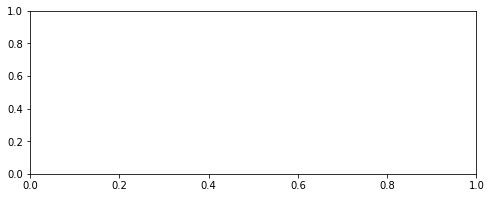

In [9]:
import libfmp.c1
score = libfmp.c1.midi_to_list(pm)

libfmp.c1.visualize_piano_roll(score, figsize=(8, 3))


(<Figure size 576x216 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd36e144c90>)

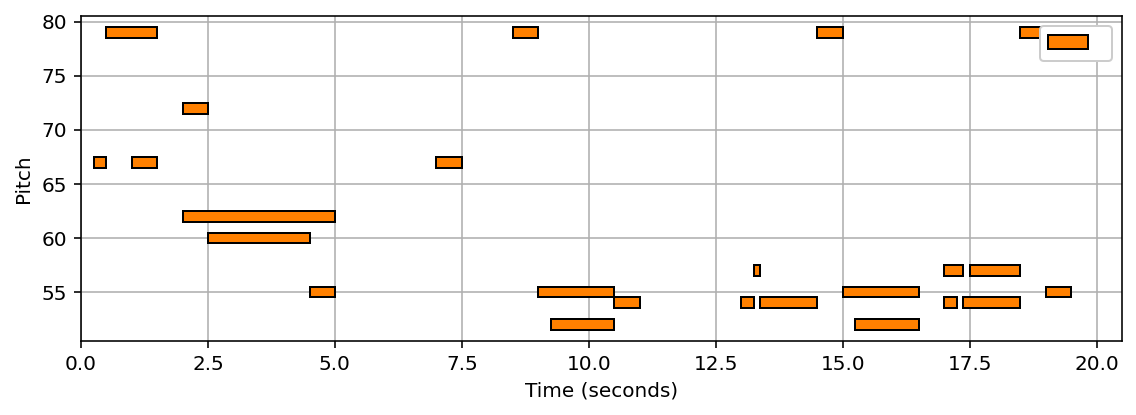

In [17]:
import libfmp.c1
score = libfmp.c1.midi_to_list(pm)

libfmp.c1.visualize_piano_roll(score, figsize=(8, 3))



#re init data for batch 128

In [10]:
#load data with batch size to be used in transformer 
traintr = dataset["train"].dataset.transform["inverse_norm"]
valtr = dataset["val"].dataset.transform["inverse_norm"]


preprocessed_train_data = []
preprocessed_train_labeldata = []
preprocessed_train_cc = []

for i, batch in enumerate(dataset["train"]): 
    x_var = batch[0].to(net.device)
    x_var = x_var.to(net.device)
    xpred_var = net.code(x_var)
    # xpred_var = x_var
    preprocessed_train_data.append(xpred_var.cpu().detach().numpy())
    preprocessed_train_labeldata.append(batch[1].cpu().detach().numpy())
    preprocessed_train_cc.append(batch[2].cpu().detach().numpy())

preprocessed_test_data = []
preprocessed_test_labeldata = []
preprocessed_test_cc = []

for i, batch in enumerate(dataset["val"]): 
    x_var = batch[0].to(net.device)
    x_var = x_var.to(net.device)
    xpred_var = net.code(x_var)
    # xpred_var = x_var
    preprocessed_test_data.append(xpred_var.cpu().detach().numpy())
    preprocessed_test_labeldata.append(batch[1].cpu().detach().numpy())
    preprocessed_test_cc.append(batch[2].cpu().detach().numpy())


preprocessed_train_data = np.array(preprocessed_train_data)
preprocessed_train_labeldata= np.array(preprocessed_train_labeldata)
preprocessed_train_cc = np.array(preprocessed_train_cc)

preprocessed_test_data = np.array(preprocessed_test_data)
preprocessed_test_labeldata = np.array(preprocessed_test_labeldata)
preprocessed_test_cc = np.array(preprocessed_test_cc)

print(preprocessed_train_data.shape)
print(preprocessed_test_data.shape)


print(preprocessed_train_labeldata.shape)
print(preprocessed_test_labeldata.shape)

print(preprocessed_train_cc.shape)
print(preprocessed_test_cc.shape)


(240008, 16, 88)
(2352, 16, 88)
(240008, 16)
(2352, 16)
(240008, 16)
(2352, 16)


In [11]:
import gc
del dataset
gc.collect()

train_data2 = {}
test_data2 = {}
train_data2['label'] = {}
test_data2['label'] = {}

train_data2['label']['chord_change']= preprocessed_train_cc
train_data2["pianoroll"] =  preprocessed_train_data  
train_data2["tchord"] =  preprocessed_train_labeldata  

test_data2['label']['chord_change'] =  preprocessed_test_cc
test_data2["pianoroll"] =  preprocessed_test_data  
test_data2["tchord"] =  preprocessed_test_labeldata  

dataset = load_data(train_data2, test_data2, batch_size=128)


data torch.Size([480016, 88])
label torch.Size([480016])
data torch.Size([37632, 88])
label torch.Size([37632])
Size of train dataset:  480016
Size of val dataset:  37632


In [12]:
#load data with batch size to be used in transformer 
traintr = dataset["train"].dataset.transform["inverse_norm"]
valtr = dataset["val"].dataset.transform["inverse_norm"]

#all
how_many_batches_train = 54320 
how_many_batches_test = 294

preprocessed_train_data = []
preprocessed_train_labeldata = []
preprocessed_train_cc = []

for i, batch in enumerate(dataset["train"]): 
    x_var = batch[0]
    xpred_var = x_var
    preprocessed_train_data.append(xpred_var.detach().numpy())
    preprocessed_train_labeldata.append(batch[1].detach().numpy())
    preprocessed_train_cc.append(batch[2].detach().numpy())
    if len(preprocessed_train_data)==how_many_batches_train: break



preprocessed_test_data = []
preprocessed_test_labeldata = []
preprocessed_test_cc = []

for i, batch in enumerate(dataset["val"]): 
    x_var = batch[0]
    xpred_var = x_var
    preprocessed_test_data.append(xpred_var.detach().numpy())
    preprocessed_test_labeldata.append(batch[1].detach().numpy())
    preprocessed_test_cc.append(batch[2].detach().numpy())
    if len(preprocessed_test_data)==how_many_batches_test: break


preprocessed_train_data = np.array(preprocessed_train_data)
preprocessed_train_labeldata= np.array(preprocessed_train_labeldata)
preprocessed_train_cc = np.array(preprocessed_train_cc)

preprocessed_test_data = np.array(preprocessed_test_data)
preprocessed_test_labeldata = np.array(preprocessed_test_labeldata)
preprocessed_test_cc = np.array(preprocessed_test_cc)






print(preprocessed_train_data.shape)
print(preprocessed_test_data.shape)


print(preprocessed_train_labeldata.shape)
print(preprocessed_test_labeldata.shape)

print(preprocessed_train_cc.shape)
print(preprocessed_test_cc.shape)


(3750, 128, 88)
(294, 128, 88)
(3750, 128)
(294, 128)
(3750, 128)
(294, 128)


# this trains Harmony transformer 

In [36]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
from HT.chord_symbol_recognition import train_HT
from collections import Counter, namedtuple
# Chord symbol recognition
# train_BTC() # Bi-directional Transformer for Chord Recognition
# train_CRNN() # Convolutional Recurrent Neural Network
train_data3 = {}
test_data3 = {}
train_data3['label'] = {}
test_data3['label'] = {}

train_data3['label']['chord_change']= preprocessed_train_cc
train_data3["len"] = np.array([128 for i in range(how_many_batches_train)])
train_data3["pianoroll"] =  preprocessed_train_data  
train_data3["tchord"] =  preprocessed_train_labeldata  
train_data3['root'] = np.zeros((how_many_batches_train,128))
train_data3['tquality'] =  np.zeros((how_many_batches_train,128))

test_data3['label']['chord_change'] =  preprocessed_test_cc
test_data3["len"] = np.array([128 for i in range(how_many_batches_test)])
test_data3["pianoroll"] =  preprocessed_test_data  
test_data3["tchord"] =  preprocessed_test_labeldata  
test_data3['root'] =  np.zeros((how_many_batches_test,128))
test_data3['tquality'] =  np.zeros((how_many_batches_test,128))

# import os
train_HT(hp, train_data3, test_data3)

# print(test_data["pianoroll"].shape, test_data2["pianoroll"].shape)
# print(test_data['label']['chord_change'].shape, test_data2['label']['chord_change'].shape)
# print(test_data["tchord"].shape, test_data2["tchord"].shape)
# print(test_data["len"].shape, test_data2["len"].shape)

Run HT chord recognition on /content/-1...
(3750, 128)
n_train_sequences = 3750
n_test_sequences = 294
n_iterations_per_epoch = 94
hyperparameters(dataset='/content/', test_set_id=1, graph_location='model', n_root_classes=13, n_tquality_classes=4, n_chord_classes=25, n_steps=128, input_embed_size=128, n_layers=2, n_heads=4, train_sequence_with_overlap=True, initial_learning_rate=0.0001, drop=0.1, n_batches=40, n_training_steps=100000, n_in_succession=10, annealing_rate=1.1)
Saving graph to: model
Train the model...
*~ loss_cc 1.2471, loss_tc 4.1299 ~*
---- step 94, epoch 1: train_loss: total 4.7212, cc 0.8169, tc 3.9043, evaluation: tc 0.0672, cc (P 0.0855, R 0.2010, F1 0.1200) ----
enc_w = [0.33292142 0.33350757 0.33357102] dec_w = [0.3327237  0.33360514 0.33367118]
len = 128
y_root    C  C  C  C  C  C  C  C  C  C  C  C  C  C  C  C  C  C  C  C  C  C  C  C  C  C  C  C  C  C  C  C  C  C  C  C  C  C  C  C  C  C  C  C  C  C  C  C  C  C  C  C  C  C  C  C  C  C  C  C  C  C  C  C
y_tq      M